# Training SimpleNN on CIFAR-10
In this project, you will use the SimpleNN model to perform image classification on CIFAR-10. CIFAR-10 orginally contains 60K images from 10 categories. We split it into 45K/5K/10K images to serve as train/valiation/test set. We only release the ground-truth labels of training/validation dataset to you.

## Step 0: Set up the SimpleNN model
As you have practiced to implement neural networks in Homework 1, we just prepare the implementation for you.

In [ ]:
# import necessary dependencies
import argparse
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def swish(x):
    return x/(1+torch.exp(-x))

In [ ]:
# define the SimpleNN mode;
class ResNet_Block(nn.Module):
    def __init__(self, in_chs, out_chs, strides):
        super(ResNet_Block, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_chs, out_channels=out_chs,
                      stride=strides, padding=1, kernel_size=3, bias=False),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=out_chs, out_channels=out_chs,
                      stride=1, padding=1, kernel_size=3, bias=False),
            nn.BatchNorm2d(out_chs)
        )

        if in_chs != out_chs:
            self.id_mapping = nn.Sequential(
                nn.Conv2d(in_channels=in_chs, out_channels=out_chs,
                          stride=strides, padding=0, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_chs))
        else:
            self.id_mapping = None
        self.final_activation = nn.ReLU(True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        if self.id_mapping is not None:
            x_ = self.id_mapping(x)
        else:
            x_ = x
        return self.final_activation(x_ + out)

class ResNetCIFAR(nn.Module):
    def __init__(self, num_layers=20, num_stem_conv=16, config=(16, 32, 64)):
        super(ResNetCIFAR, self).__init__()
        self.num_layers = 20
        self.head_conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=num_stem_conv,
                      stride=1, padding=1, kernel_size=3, bias=False),
            nn.BatchNorm2d(num_stem_conv),
            nn.ReLU(True)
        )
        num_layers_per_stage = (num_layers - 2) // 6
        self.body_op = []
        num_inputs = num_stem_conv
        for i in range(len(config)):
            for j in range(num_layers_per_stage):
                if j == 0 and i != 0:
                    strides = 2
                else:
                    strides = 1
                self.body_op.append(ResNet_Block(num_inputs, config[i], strides))
                num_inputs = config[i]
        self.body_op = nn.Sequential(*self.body_op)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.final_fc = nn.Linear(config[-1], 10)

    def forward(self, x):
        out = self.head_conv(x)
        out = self.body_op(out)
        self.features = self.avg_pool(out)
        self.feat_1d = self.features.mean(3).mean(2)
        return self.final_fc(self.feat_1d)

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        return torch.cat([x, out], 1)

class BottleneckBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BottleneckBlock, self).__init__()
        inter_planes = out_planes * 4
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, inter_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(inter_planes)
        self.conv2 = nn.Conv2d(inter_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        out = self.conv2(self.relu(self.bn2(out)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return torch.cat([x, out], 1)

class TransitionBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(TransitionBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return F.avg_pool2d(out, 2)

class DenseBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, growth_rate, block, dropRate=0.0):
        super(DenseBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, growth_rate, nb_layers, dropRate)
    def _make_layer(self, block, in_planes, growth_rate, nb_layers, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(in_planes+i*growth_rate, growth_rate, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class DenseNet3(nn.Module):
    def __init__(self, depth, num_classes, growth_rate=12,
                 reduction=0.5, bottleneck=True, dropRate=0.0):
        super(DenseNet3, self).__init__()
        in_planes = 2 * growth_rate
        n = (depth - 4) / 3
        if bottleneck == True:
            n = n/2
            block = BottleneckBlock
        else:
            block = BasicBlock
        # 1st conv before any dense block
        self.conv1 = nn.Conv2d(3, in_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        self.trans1 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)), dropRate=dropRate)
        in_planes = int(math.floor(in_planes*reduction))
        # 2nd block
        self.block2 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        self.trans2 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)), dropRate=dropRate)
        in_planes = int(math.floor(in_planes*reduction))
        # 3rd block
        self.block3 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(in_planes, num_classes)
        self.in_planes = in_planes

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.block1(out))
        out = self.trans2(self.block2(out))
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.in_planes)
        return self.fc(out)

In [ ]:
# define the Resnet20 mode;
class Resnet20(nn.Module):
    def __init__(self):
        super(Resnet20, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.batchnorm0 = nn.BatchNorm2d(16)
        
        self.conv1a = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1a = nn.BatchNorm2d(16)
        self.conv1b = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1b = nn.BatchNorm2d(16)
        self.conv1c = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1c = nn.BatchNorm2d(16)
        self.conv1d = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1d = nn.BatchNorm2d(16)
        self.conv1e = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1e = nn.BatchNorm2d(16)
        self.conv1f = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1f = nn.BatchNorm2d(16)
        
        self.conv1_2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.batchnorm1_2 = nn.BatchNorm2d(32)
        self.bypass1_2 = nn.Conv2d(16, 32, 1, stride=2)
        self.conv2a = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2a = nn.BatchNorm2d(32)
        self.conv2b = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2b = nn.BatchNorm2d(32)
        self.conv2c = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2c = nn.BatchNorm2d(32)
        self.conv2d = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2d = nn.BatchNorm2d(32)
        self.conv2e = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2e = nn.BatchNorm2d(32)
        
        self.conv2_3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.batchnorm2_3 = nn.BatchNorm2d(64)
        self.bypass2_3 = nn.Conv2d(32, 64, 1, stride=2)
        self.conv3a = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3a = nn.BatchNorm2d(64)
        self.conv3b = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3b = nn.BatchNorm2d(64)
        self.conv3c = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3c = nn.BatchNorm2d(64)
        self.conv3d = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3d = nn.BatchNorm2d(64)
        self.conv3e = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3e = nn.BatchNorm2d(64)
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        # Inital convolution
        out = self.batchnorm0(self.conv0(x))
        out = bypass = swish(out)
        # Block 1   (condense block layers into functions)
            # Layer 1
        out = self.batchnorm1a(self.conv1a(out))
        out = swish(out)
        out = self.batchnorm1b(self.conv1b(out))
        out = bypass = swish(out + bypass)
            # Layer 2
        out = self.batchnorm1c(self.conv1c(out))
        out = swish(out)
        out = self.batchnorm1d(self.conv1d(out))
        out = bypass = swish(out + bypass)
            # Layer 3
        out = self.batchnorm1e(self.conv1e(out))
        out = swish(out)
        out = self.batchnorm1f(self.conv1f(out))
        out = bypass = swish(out + bypass)
        # Block 2
            # Layer 1
        bypass = self.bypass1_2(bypass)
        out = self.batchnorm1_2(self.conv1_2(out))
        out = swish(out)
        out = self.batchnorm2a(self.conv2a(out))
        out = bypass = swish(out + bypass)
            # Layer 2
        out = self.batchnorm2b(self.conv2b(out))
        out = swish(out)
        out = self.batchnorm2c(self.conv2c(out))
        out = bypass = swish(out + bypass)
            # Layer 3
        out = self.batchnorm2d(self.conv2d(out))
        out = swish(out)
        out = self.batchnorm2e(self.conv2e(out))
        out = bypass = swish(out + bypass)
        # Block 3
            # Layer 1
        bypass = self.bypass2_3(bypass)
        out = self.batchnorm2_3(self.conv2_3(out))
        out = swish(out)
        out = self.batchnorm3a(self.conv3a(out))
        out = bypass = swish(out + bypass)
            # Layer 2
        out = self.batchnorm3b(self.conv3b(out))
        out = swish(out)
        out = self.batchnorm3c(self.conv3c(out))
        out = bypass = swish(out + bypass)
            # Layer 3
        out = self.batchnorm3d(self.conv3d(out))
        out = swish(out)
        out = self.batchnorm3e(self.conv3e(out))
        out = bypass = swish(out + bypass)
        
        # Global Average Pool to go from 8x8 -> 1x1 feature maps
        out = F.avg_pool2d(out, 8)
        
        # Fully Connected Layer
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

## Step 1: Set up preprocessing functions
Preprocessing is very important as discussed in the lecture.
You will need to write preprocessing functions with the help of *torchvision.transforms* in this step.
You can find helpful tutorial/API at [here](https://pytorch.org/vision/stable/transforms.html).

### Question (b)
For the question, you need to:
1. Complete the preprocessing code below.
2. **In the PDF report**, briefly describe what preprocessing operations you used and what are the purposes of them.

Hint: 
1. Only two operations are necessary to complete the basic preprocessing here.
2. The raw input read from the dataset will be PIL images.
3. Data augmentation operations are not mendatory, but feel free to incorporate them if you want.
4. Reference value for mean/std of CIFAR-10 images (assuming the pixel values are within [0,1]): mean (RGB-format): (0.4914, 0.4822, 0.4465), std (RGB-format): (0.2023, 0.1994, 0.2010)

In [ ]:
# useful libraries
import torchvision
import torchvision.transforms as transforms


#############################################
# your code here
# specify preprocessing function
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
#############################################

**Answer**


ToTensor() and Normalize() is enough in this question. ToTensor() transforms PIL images to torch.tensor, and the element's value will be in [0,1]. Normalize() normalizes the tensor to have zero mean and unit standard deviation.

## Step 2: Set up dataset and dataloader

### Question (c)
Set up the train/val datasets and dataloders that are to be used during the training. Check out the [official API](https://pytorch.org/docs/stable/data.html) for more information about **torch.utils.data.DataLoader**.

Here, you need to:
1. Complete the code below.

In [ ]:
# do NOT change these
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

#############################################
# your code here
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT, 
    mode='train', 
    download=True,
    transform=transform_train # your code
)
val_set = CIFAR10(
    root=DATA_ROOT, 
    mode='val', 
    download=True,
    transform=transform_val # your code
)

# construct dataloader
train_loader = DataLoader(
    train_set, 
    batch_size=TRAIN_BATCH_SIZE, # your code
    shuffle=True, # your code
    num_workers=4
)
val_loader = DataLoader(
    val_set, 
    batch_size=VAL_BATCH_SIZE, # your code
    shuffle=False, # your code
    num_workers=4
)
#############################################

0it [00:00, ?it/s]

Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified


## Step 3: Instantiate your SimpleNN model and deploy it to GPU devices.
### Question (d)
You may want to deploy your model to GPU device for efficient training. Please assign your model to GPU if possible. If you are training on a machine without GPUs, please deploy your model to CPUs.

Here, you need to:
1. Complete the code below.
2. **In the PDF report**, briefly describe how you verify that your model is indeed deployed on GPU. (Hint: check $\texttt{nvidia-smi}$.)

In [ ]:
# specify the device for computation
#############################################
# your code here

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = Resnet20()
net = net.to(device)
if device == 'cuda':
    print("Train on GPU...")
else:
    print("Train on CPU...")
    
#############################################

Train on GPU...


In [ ]:
import torch
if torch.cuda.is_available():
  print("yes")

yes


## Step 4: Set up loss functions and Optimizers
Loss function/objective function is used to provide "feedback" for the neural networks. Typically, we use multi-class cross-entropy as the loss function for classification models. As for the optimizer, we will use SGD with momentum. 

### Question (e)
Here, you need to:
1. Set up the cross-entropy loss as the criterion. (Hint: there are implemented functions in **torch.nn**. Be careful about the required inputs to the loss function. Are the inputs the logits or softmax probabilities?)
2. Specify a SGD optimizer with momentum. (Hint: there are implemented functions in **torch.optim**)

In [ ]:
import torch.nn as nn
import torch.optim as optim

# hyperparameters, do NOT change right now
# initial learning rate
INITIAL_LR = 0.1

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 5e-4

#############################################
# your code here
# create loss function
criterion = nn.CrossEntropyLoss()

# Add optimizer
optimizer = optim.SGD(params=net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)
#############################################

## Step 5: Start the training process.

### Question (f)/(g)
Congratulations! You have completed all of the previous steps and it is time to train our neural network.
Training a neural network usually repeats the following 3 steps: 

**i) Get a batch of data from the dataloader and copy it to your device (GPU).**

**ii) Do a forward pass to get the output logits from the neural network. Compute the forward loss.**

**iii) Do a backward pass (back-propagation) to compute gradients of all weights with respect to the loss.**

**iiii) Update the model weights with the optimizer.**

You will also need to compute the accuracy of training/validation samples to track your model's performance over each epoch (the accuracy should be increasing as you train for more and more epochs).


In [ ]:
# some hyperparameters
# total number of training epochs
EPOCHS = 200

# learning rate decay policy
DECAY_EPOCHS = [100, 150] # this is not strict, [70, 140] can also work pretty well
DECAY = 0.1

# the folder where the trained model is saved
CHECKPOINT_PATH = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    # handle the learning rate scheduler.
    if i in DECAY_EPOCHS:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)
    
    
    #######################
    # your code here
    # switch to train mode
    net.train()
    #######################
    
    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want
    
    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        
        # zero the gradient
        optimizer.zero_grad()
        
        # backpropagation
        loss.backward()
        
        # apply gradient and update the weights
        optimizer.step()
        
        # count the number of correctly predicted samples in the current batch
        _, predicted = outputs.max(1)
        total_examples += predicted.size(0)
        correct_examples += predicted.eq(targets).sum().item()
        train_loss += loss.item()
        ####################################
                
    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()
    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0
    
    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # compute the output and loss
            outputs = net(inputs)
            
            loss = criterion(outputs, targets)
            
            # count the number of correctly predicted samples in the current batch
            _, predicted = outputs.max(1)
            total_examples += predicted.size(0)
            correct_examples += predicted.eq(targets).sum().item()
            val_loss += loss
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_PATH):
            os.makedirs(CHECKPOINT_PATH)
        print("Saving ...")
        state = {'net': net.state_dict(),
                 'epoch': i,
                 'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_PATH, 'resnet_new.h5'))
        
    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 1.6953, Training accuracy: 0.3646
Validation loss: 2.2581, Validation accuracy: 0.3486
Saving ...

Epoch 1:
Training loss: 1.2478, Training accuracy: 0.5481
Validation loss: 1.1567, Validation accuracy: 0.5954
Saving ...

Epoch 2:
Training loss: 0.9633, Training accuracy: 0.6581
Validation loss: 1.3221, Validation accuracy: 0.5964
Saving ...

Epoch 3:
Training loss: 0.8269, Training accuracy: 0.7111
Validation loss: 1.1094, Validation accuracy: 0.6300
Saving ...

Epoch 4:
Training loss: 0.7498, Training accuracy: 0.7394
Validation loss: 1.1124, Validation accuracy: 0.6524
Saving ...

Epoch 5:
Training loss: 0.6978, Training accuracy: 0.7586
Validation loss: 0.9324, Validation accuracy: 0.6986
Saving ...

Epoch 6:
Training loss: 0.6589, Training accuracy: 0.7714
Validation loss: 0.6767, Validation accuracy: 0.7672
Saving ...

Epoch 7:
Training loss: 0.6268, Training accuracy: 0.7856
Validation loss: 0.8200, Validation accuracy: 0.7304

Epoch 

## Save predictions on test data

In [ ]:
from tools.dataset import CIFAR10

net = Resnet20()
chkpnt = torch.load('./resnet20.pth')['state_dict']
net.load_state_dict(chkpnt)
net.cuda()
net.eval()

test_set = CIFAR10(
    root=DATA_ROOT, 
    mode='test', 
    transform=transform_val
)

# do NOT shuffle your test data loader
# otherwise the order of samples will be messed up
# and your test accuracy is likely to drop to random guessing level
test_loader = DataLoader(
    test_set, batch_size=200, shuffle=False, num_workers=1)

results = []
with torch.no_grad():
    for x in test_loader:
        y = net(x.cuda()).argmax(1).cpu()
        results.append(y)
    
results = torch.cat(results)
if isinstance(results, torch.Tensor):
    results = results.cpu().numpy()
    
with open('predictions.csv', 'w') as fp:
    fp.write("Id,Label\n")
    for i in range(len(results)):
        fp.write("%d,%d\n" %(i, results[i]))

NameError: ignored

## Our baseline test acc

**0.9252**

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from tools.dataset import CIFAR10
import torch.nn.functional as F
def softmax(val, T =25):
  x = val.cpu().detach()
  out = torch.zeros(x.size())

  for i in range(len(out)):
    sum = 0
    for j in range(len(out[0])):
      out[i][j] = np.exp(x[i][j]/1)
      sum+= out[i][j]
    out[i] = out[i]/sum
  return out

In [ ]:
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:

from torchvision.datasets import CIFAR10
from torchvision.datasets import CIFAR100
DATA_ROOT = "./data"
OOD_Data = CIFAR100(
    root=DATA_ROOT,
    train=False,
    transform=transform_val,
    download=True
)
ID_Data = CIFAR10(
    root=DATA_ROOT,
    train=False,
    transform=transform_val,
    download=True
)

ID_loader = DataLoader(
    ID_Data, 
    batch_size=200, # your code
    shuffle=False, # your code
    num_workers=1
)
OOD_loader = DataLoader(
    OOD_Data, 
    batch_size=200, # your code
    shuffle=False, # your code
    num_workers=1
)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
net = Resnet20()
chkpnt = torch.load('./resnet20.pth')['state_dict']
net.load_state_dict(chkpnt)
#chkpnt = torch.load('./resnet_new.h5')
#net.load_state_dict(chkpnt['net'])


net.cuda()
net.eval()
softmaxes = []
indexes = []

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(ID_loader):
        inputs = inputs.to(device)
        y = net(inputs.cuda())
        softmaxes.append(softmax(y).amax(1).cpu())
        indexes.append(y.argmax(1).cpu())

indexes = torch.cat(indexes)
softmaxes = torch.cat(softmaxes)
total_examples = indexes.size()[0]


    

In [ ]:
def plot_true_pos(vals):
  TPRs = []
  opt = .95
  opt_x = 0
  opt_y = 0
  dist = 1000
  x_range = np.linspace(.0, 1, 1000)
  for i in x_range:
    TPR = sum(vals > i)/len(vals)
    TPRs.append(TPR)
    if(np.abs(opt-TPR)<dist):
      opt_x, opt_y, dist= i, TPR, (np.abs(opt-TPR))
  plt.plot( x_range,TPRs, 'm')
  plt.plot(opt_x, opt_y, 'X', ms=11, label="Threshold at 95%")
  plt.xlabel("Threshold")
  plt.ylabel("True Positive Rate")
  plt.title("In-Distribution Threshold for TPR")
  plt.legend()
  plt.show()
  print(f"Threshold at 95% = {opt_x}")

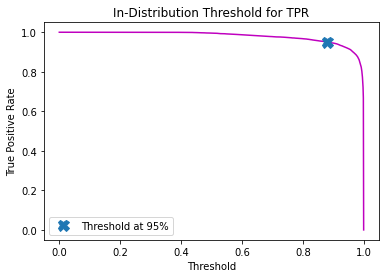

Threshold at 95% = 0.8788788788788788


In [ ]:
plot_true_pos(softmaxes)

In [ ]:
def plot_roc(ID_vals, OOD_vals, title):
  TPRs = []     #  true positive rates
  FPRs = []     # false positive rates
  opt = .95
  opt_TPR = 0
  opt_FPR = 0
  dist = 1000
  for i in np.linspace(min([min(ID_vals), min(OOD_vals)]), max([max(ID_vals), max(OOD_vals)]), 1000):
      TPR = sum(ID_vals > i)/len(ID_vals)
      FPR = sum(OOD_vals > i)/len(OOD_vals)
      TPRs.append(TPR)
      FPRs.append(FPR)
      if(np.abs(opt-TPR)<dist):
        opt_TPR, opt_FPR, dist= TPR, FPR, (np.abs(opt-TPR))
  plt.plot(FPRs, TPRs, 'm')
  plt.plot([0,1], [0,1], "k--", linewidth=.5)
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(title)
  plt.plot(opt_FPR, opt_TPR, 'X', ms=11, label=f"95% TPR")
  plt.legend()
  plt.show()
  print(f"FPR at 95% = {opt_FPR}")

In [ ]:

OOD_softmaxes = []
indexes = []

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(OOD_loader):
        inputs = inputs.to(device)
        y = net(inputs.cuda())
        OOD_softmaxes.append(softmax(y).amax(1).cpu())
        indexes.append(y.argmax(1).cpu())

indexes = torch.cat(indexes)
OOD_softmaxes = torch.cat(OOD_softmaxes)
total_examples = indexes.size()[0]


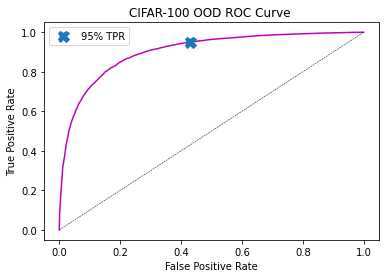

FPR at 95% = 0.42809998989105225


In [ ]:
plot_roc(softmaxes, OOD_softmaxes, "CIFAR-100 OOD ROC Curve ")

In [ ]:
from torchvision.datasets import SVHN

SVHN_OOD_Data = SVHN(
    root=DATA_ROOT,
    split="test",
    transform=transform_val,
    download=True
)
SVHN_OOD_loader = DataLoader(
    SVHN_OOD_Data, 
    batch_size=200, # your code
    shuffle=False, # your code
    num_workers=1
)

  0%|          | 0/64275384 [00:00<?, ?it/s]

In [ ]:

OOD_softmaxes = []
indexes = []

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(SVHN_OOD_loader):
        inputs = inputs.to(device)
        y = net(inputs.cuda())
        OOD_softmaxes.append(softmax(y).amax(1).cpu())
        indexes.append(y.argmax(1).cpu())

indexes = torch.cat(indexes)
OOD_softmaxes = torch.cat(OOD_softmaxes)
total_examples = indexes.size()[0]

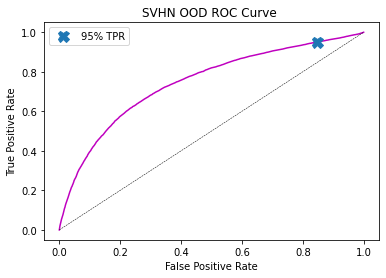

FPR at 95% = 0.8476874828338623


In [ ]:
plot_roc(softmaxes, OOD_softmaxes, "SVHN OOD ROC Curve ")

In [ ]:
pip install lmdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchvision.datasets import MNIST
transform_MNIST = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914), (0.2023)),

])
MNIST_OOD_Data = MNIST(
    root=DATA_ROOT,
    train=False,
    transform=transform_MNIST,
    download = True

)
MNIST_OOD_loader = DataLoader(
    MNIST_OOD_Data, 
    batch_size=200, # your code
    shuffle=False, # your code
    num_workers=1
)

In [ ]:
import tensorflow2 as tf
OOD_softmaxes = []
indexes = []

with torch.no_grad():
    for batch_idx, (inputs1, targets1) in enumerate(MNIST_OOD_loader):
        x = inputs1.numpy()
        x = tf.image.grayscale_to_rgb(x, name=None)
        inputs1 = tf.convert_to_tensor(x)
        inputs1 = inputs1.to(device)
        y = net(inputs1.cuda())
        OOD_softmaxes.append(softmax(y).amax(1).cpu())
        indexes.append(y.argmax(1).cpu())

indexes = torch.cat(indexes)
OOD_softmaxes = torch.cat(OOD_softmaxes)
total_examples = indexes.size()[0]

ModuleNotFoundError: ignored